<a href="https://colab.research.google.com/github/JoDeMiro/TimeSeriesLearn/blob/main/06_TSLearn_Early_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Early Classification

This example presents the concept of early classification.

Early classifiers are implemented in the 
:mod:`tslearn.early_classification` module and in this example 
we use the method from [1].


[1] A. Dachraoui, A. Bondu & A. Cornuejols. Early classification of time
series as a non myopic sequential decision making problem. ECML/PKDD 2015


In [1]:
!pip install -q tslearn

     |████████████████████████████████| 793 kB 4.0 MB/s 


In [2]:
# Author: Romain Tavenard
# License: BSD 3 clause
# sphinx_gallery_thumbnail_number = 2

import numpy
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.early_classification import NonMyopicEarlyClassifier
from tslearn.datasets import UCR_UEA_datasets

def plot_partial(time_series, t, y_true=0, y_pred=0, color="k"):
    plt.plot(time_series[:t+1].ravel(), color=color, linewidth=1.5)
    plt.plot(numpy.arange(t+1, time_series.shape[0]),
             time_series[t+1:].ravel(),
             linestyle="dashed", color=color, linewidth=1.5)
    plt.axvline(x=t, color=color, linewidth=1.5)
    plt.text(x=t - 20, y=time_series.max() - .25, s="Prediction time")
    plt.title(
        "Sample of class {} predicted as class {}".format(y_true, y_pred)
    )
    plt.xlim(0, time_series.shape[0] - 1)

## Data loading and visualization



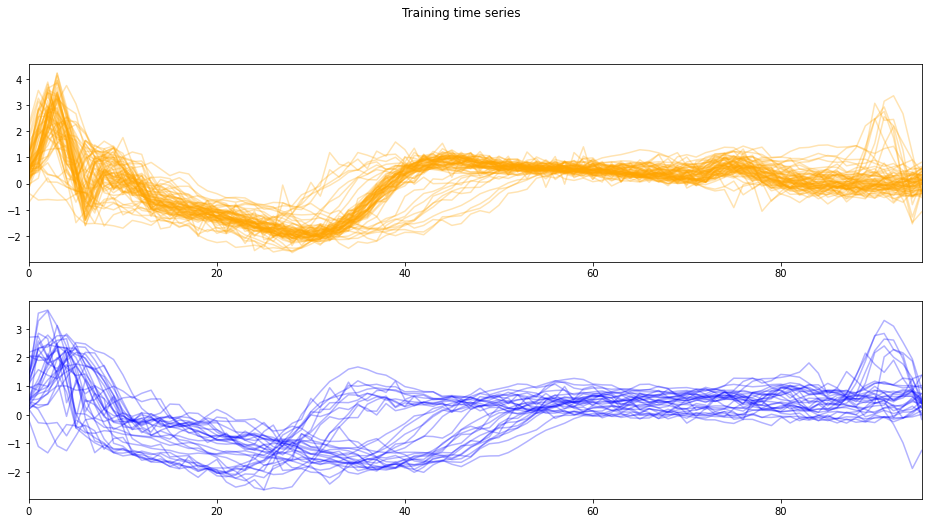

In [6]:
numpy.random.seed(0)
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("ECG200")

# Scale time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance().fit_transform(X_test)

size = X_train.shape[1]
n_classes = len(set(y_train))

plt.figure(figsize=(16, 8))
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    for ts in X_train[y_train == cl]:
        plt.plot(ts.ravel(), color="orange" if cl > 0 else "blue", alpha=.3)
    plt.xlim(0, size - 1)
plt.suptitle("Training time series")
plt.show()

## Model fitting

As observed in the following figure, the optimal classification time as
estimated by `NonMyopicEarlyClassifier` is data-dependent.



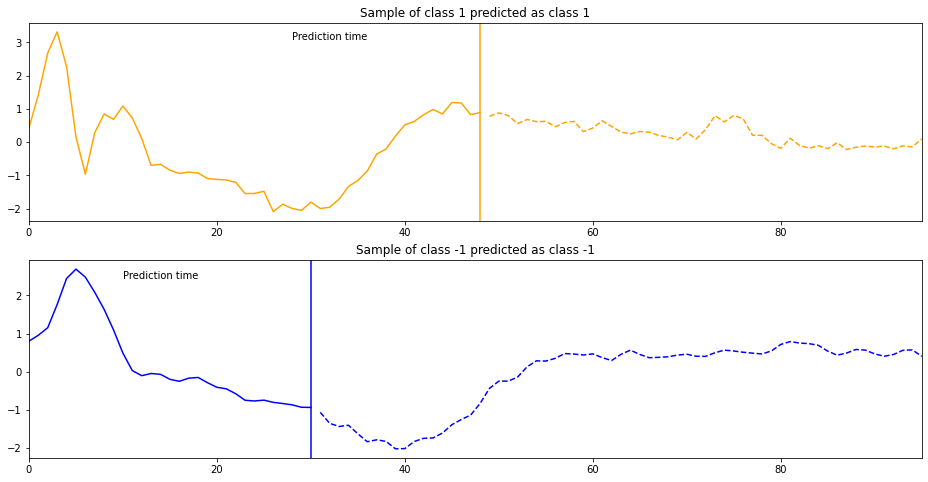

In [7]:
early_clf = NonMyopicEarlyClassifier(n_clusters=3,
                                     cost_time_parameter=1e-3,
                                     lamb=1e2,
                                     random_state=0)
early_clf.fit(X_train, y_train)

preds, times = early_clf.predict_class_and_earliness(X_test)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
ts_idx = 0
t = times[ts_idx]
plot_partial(X_test[ts_idx], t, y_test[ts_idx], preds[ts_idx], color="orange")


plt.subplot(2, 1, 2)
ts_idx = 9
t = times[ts_idx]
plot_partial(X_test[ts_idx], t, y_test[ts_idx], preds[ts_idx], color="blue")
# plt.tight_layout()
plt.show()

## Earliness-Accuracy trade-off

The trade-off between earliness and accuracy is controlled via
``cost_time_parameter``.



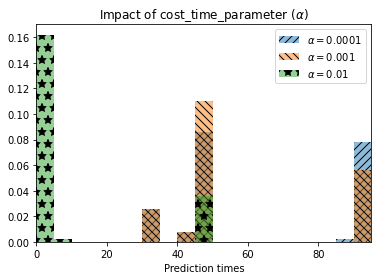

In [5]:
plt.figure()
hatches = ["///", "\\\\\\", "*"]
for i, cost_t in enumerate([1e-4, 1e-3, 1e-2]):
    early_clf.set_params(cost_time_parameter=cost_t)
    early_clf.fit(X_train, y_train)
    preds, times = early_clf.predict_class_and_earliness(X_test)
    plt.hist(times,
             alpha=.5, hatch=hatches[i],
             density=True,
             label="$\\alpha={}$".format(cost_t),
             bins=numpy.arange(0, size, 5))
plt.legend(loc="upper right")
plt.xlim(0, size - 1)
plt.xlabel("Prediction times")
plt.title("Impact of cost_time_parameter ($\\alpha$)")
plt.show()